In [1]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from matplotlib.pyplot import imshow
%matplotlib inline

%matplotlib-  IPython 에서 제공하는 Rich output(그림, 소리, 애니메이션) 에 대한 표현 방식  
https://korbillgates.tistory.com/85

inline 브라우저(실행코드 창 1줄) 내부에서 바로 Rich output출력  
https://korbillgates.tistory.com/85

In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### 학습시작

In [4]:
import torch
import torch.nn as nn                     ## 손실함수
import torch.nn.functional as F

import torch.optim as optim               ## optimizer
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

.manual_seed : random seed(난수 발생)를 고정하기 위한 함수, 동일한 셋트의 난수를 생성할 수 있게 하는 것이다.  
https://rabo0313.tistory.com/entry/pytorch-torchmanualseed

 torch.manual_seed : cpu 연산 무작위 고정  
 torch.manual_seed_all: 멀티 gpu 연산 고정
 https://www.facebook.com/groups/PyTorchKR/posts/927731617366520/?mibextid=HsNCOg

In [6]:
# 정규화 설정
transform = transforms.Compose( # 여러단계로 변환 시 묶어서 사용할 수 있게 함.
    [transforms.ToTensor(), # 데이터를 Tensor로 변환환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (mean, std, inplace=False) / 
                                                              # (R채널 평균, G ", B "), (R채널 표준편차, G ", B ") 
                                                              # 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화.

batch_size = 13

# 데이터세트 불러오기기
trainset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/ETC/2022/Competition_DentalAI/apple_dataset/train',
                                             transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/ETC/2022/Competition_DentalAI/apple_dataset/test',
                                             transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

In [ ]:
len(classes)

13

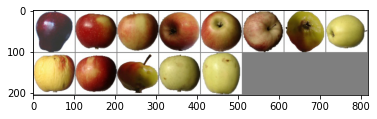

Apple Red Delicious Apple Braeburn Apple Red 2 Apple Pink Lady Apple Red 2 Apple Red 3 Apple Red Yellow 2 Apple Golden 2 Apple Red Yellow 1 Apple Braeburn Apple Red Yellow 2 Apple Golden 3 Apple Golden 2


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### 모델 불러오기

In [8]:
import torchvision.models as models
from torchsummary import summary

model = models.mobilenet_v3_small(num_classes=13).to(device)

In [9]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

##### 오류코드 1, 2 : 해결됨

In [ ]:
#오류 코드 1 _ 20221121 : 해결됨

for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

In [ ]:
#오류 코드 2 _ 20221122 : 해결됨
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs.cuda())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        inputs = inputs.cpu()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

##### 모델 학습

In [12]:

for epoch in range(2):   # 데이터셋을 수차례 반복합니다. epoch : 2 / batch_size : 13 (class  개수대로)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs.cuda())
        loss = criterion(outputs.cpu(), labels) # criterion
        loss.backward()
        optimizer.step()
        # inputs = inputs.cpu()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}') # loss : loss 평균값 출력
                                                                      # .3f:소수점 3자리만 출력
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.950
[1,   200] loss: 1.861
[1,   300] loss: 1.631
[1,   400] loss: 1.458
[2,   100] loss: 1.142
[2,   200] loss: 0.982
[2,   300] loss: 0.812
[2,   400] loss: 0.657
Finished Training


iter  
next

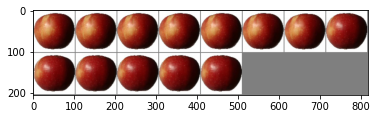

GroundTruth:  Apple Braeburn Apple Braeburn Apple Braeburn Apple Braeburn


In [22]:
# 오류 코드 3 : 해결됨 : 배치 사이즈가 4여서 아예 없는 클래스 부르려니까 오류 났음
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [17]:
outputs = model(images.cuda())

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(13)))

Predicted:  Apple Pink Lady Apple Red Yellow 2 Apple Pink Lady Apple Golden 1


##### 오류코드 4 : 해결됨

In [64]:
# 오류 코드 4 : 해결됨
# cpu, gpu 혼선

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.cuda())
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: ignored

#### 전체 데이터셋에 대해 어떻게 작동하는가

In [20]:
# 오류 코드 4

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.cuda())
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [25]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Apple Braeburn is 14.0 %
Accuracy for class: Apple Crimson Snow is 8.1 %
Accuracy for class: Apple Golden 1 is 8.1 %
Accuracy for class: Apple Golden 2 is 9.1 %
Accuracy for class: Apple Golden 3 is 3.7 %
Accuracy for class: Apple Granny Smith is 7.3 %
Accuracy for class: Apple Pink Lady is 7.2 %
Accuracy for class: Apple Red 1 is 9.8 %
Accuracy for class: Apple Red 2 is 7.3 %
Accuracy for class: Apple Red 3 is 13.9 %
Accuracy for class: Apple Red Delicious is 13.9 %
Accuracy for class: Apple Red Yellow 1 is 13.4 %
Accuracy for class: Apple Red Yellow 2 is 14.2 %
